# Работа 3. PID-регулятор

## 1. Описание системы (вариант 4)

Маятник – тело с массой $0.3$ кг, моментом инерции относительно оси $a$ кг∙$м^2$, центр его тяжести находится на расстоянии $50$ см от оси, момент силы трения в оси пропорционален угловой скорости вращения с коэффициентом $0.05$.

Положим $a = 0.15$

In [1]:
# m - масса в кг
# g - ускорение свободного падения в м/с^2
# R - расстояние от оси до центра тяжести в м
# k - коэффициент трения (сила трения пропорциональна угловой скорости)
# im - момент инерции относительно оси в кг*м:2
m, g, R, k, im = 0.3, 10, 0.5, 0.05, 0.15

## 2. Дифференциальное уравнение и передаточная функция

Согласно 2-ому закону Ньютона
$$
\begin{align*}
I \ddot{\theta} = m g R \sin{\theta} - k \dot{\theta} + M
\end{align*}
$$

Считая угол $\theta$ малым, можем записать
$$
\begin{align*}
(I p^2 + k p - m g R) \theta = M
\end{align*}
$$

Разделив на $I$ обе части уравнения и подставив значения, получаем
$$
\begin{align*}
(p^2 + \frac{1}{3} p - 10) \theta = \frac{20}{3} M
\end{align*}
$$

In [2]:
# символ оператора, применяемого к входному сигналу
eng_num = [1]

# символ оператора, применяемого к выходному сигналу
eng_den = [im, k, -m*g*R]

Передаточная функция системы равна
$$
\begin{align*}
W(s) = \frac{1}{I s^2 + k s - m g R} = \frac{\frac{20}{3}}{s^2 + \frac{1}{3} s - 10}
\end{align*}
$$

## 3. Уравнения состояния

In [3]:
import numpy as np
from numpy import linalg
from scipy import signal
import matplotlib.pyplot as plt

In [4]:
# представим систему с помощью уравнений состояния
sys = signal.tf2ss(eng_num, eng_den)
print(sys)

(array([[-0.33333333, 10.        ],
       [ 1.        ,  0.        ]]), array([[1.],
       [0.]]), array([[0.        , 6.66666667]]), array([[0.]]))


Получаем матрицы
$$
\begin{equation*}
    A = \left(\begin{array}{cc} 
        -\frac{1}{3} && 10 \\
        1 && 0
    \end{array}\right),
    B = \left(\begin{array}{c}
        1 \\
        0
    \end{array}\right),
    C = \left(\begin{array}{cc}
        0 && \frac{20}{3}
    \end{array}\right),
    D = 0
\end{equation*}
$$

Другими словами, исходное уравнение равносильно системе
$$
\begin{equation*}
     \begin{cases}
         \dot{z_1} = -\frac{1}{3} z_1 + 10 z_2 + M, \\
         \dot{z_2} = z_1, \\
         \theta = \frac{20}{3} z_2
     \end{cases}
\end{equation*}
$$

Из этой системы получаем
$$
\begin{equation*}
     \begin{cases}
         z_1 = \frac{3}{20} \dot{\theta}, \\
         z_2 = \frac{3}{20} \theta
     \end{cases}
\end{equation*}
$$

Таким образом, $z_1$ пропорциональна угловой скорости, $z_2$ пропорциональна углу отклонения

## 4. Свободное движение маятника

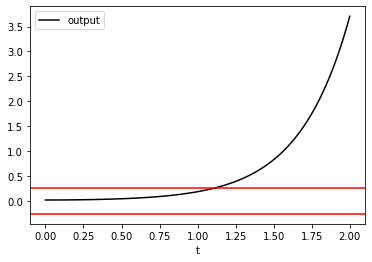

In [5]:
# задаём временной интервал
t = np.linspace(0.0, 2.0, 101)

# задаём входной сигнал;
sig = np.zeros(t.size)

# задаём начальные условия
start_pos = np.pi / 180.0
init_cond = [0, 3 / 20 * start_pos]

# задаём границы применения модели
limit = 15 * np.pi / 180.0

# пропускаем через систему
tout, yout, xout = signal.lsim(sys, sig, t, X0=init_cond)

# выводим положение маятника
plt.figure()
plt.plot(tout, yout, color='black', label='output')
plt.axhline(limit, color='r')
plt.axhline(-limit, color='r')
plt.legend(loc=0)
plt.xlabel('t')
plt.show()

При свободном движении из малого ненулевого угла маятник падает

## 5. Система с PID-регулятором

Эмпирическим путём было выяснено, что матрицы в пространстве состояний (при использовании signal.tf2ss) выглядят следующим образом
$$
\begin{equation*}
    \mathcal{A} = \left(\begin{array}{cc} 
        -(\frac{1}{3} + \frac{20}{3} D) && 3 - \frac{20}{3} P && -\frac{20}{3} I \\
        1 && 0 && 0 \\
        0 && 1 && 0
    \end{array}\right),
    \mathcal{B} = \left(\begin{array}{c}
        1 \\
        0 \\
        0
    \end{array}\right),
    \mathcal{C} = \left(\begin{array}{cc}
        \frac{20}{3} D && \frac{20}{3} P && \frac{20}{3} I
    \end{array}\right),
    \mathcal{D} = 0
\end{equation*}
$$
где $P, I, D$ - параметры регулятора  
  
При отсутствии внешнего воздействия получаем систему
$$
\begin{equation*}
     \begin{cases}
         \dot{z_1} = a z_1 + b z_2 + c z_3, \\
         \dot{z_2} = z_1, \\
         \dot{z_3} = z_2, \\
         \theta = d z_1 + e z_2 + f z_3
     \end{cases}
\end{equation*}
$$
где $a = -\frac{1 + 20 D}{3}, b = \frac{60 - 20 P}{3}, c = -\frac{20 I}{3}, d = \frac{20 D}{3}, e = \frac{20 P}{3}, f = \frac{20 I}{3}$  
  
Для дальнейшей работы перепишем систему в виде
\begin{equation*}
    \left(
        \begin{array}{cccc}
        d && e && f \\
        d a + e && d b + f && d c \\
        d a^2 + d b + e a + f && d a b + d c + e b && d a c + e c
        \end{array}
    \right) \cdot \left(\begin{array}{c}
        z_1 \\
        z_2 \\
        z_3
        \end{array}
    \right) = \left(\begin{array}{c}
        \theta \\
        \dot{\theta} \\
        \ddot{\theta}
        \end{array}
    \right)
\end{equation*}

In [6]:
def init_cond(P, I, D, pos, vel=0.0, acc=0.0):
    
    '''Вычисляем начальный вектор в пространстве состояний'''
    
    # строим матрицу, связывающую переменные в пространстве состояний и производные угла отклонения
    a, b, c, d, e, f = -(1+20*D)/3, (60-20*P)/3, -20*I/3, 20*D/3, 20*P/3, 20*I/3
    mtrx = np.array([[d, e, f], 
                     [d*a+e, d*b+f, d*c], 
                     [d*a*a+d*b+e*a+f, d*a*b+d*c+e*b, d*a*c+e*c]])

    return np.linalg.solve(mtrx, [pos, vel, acc])

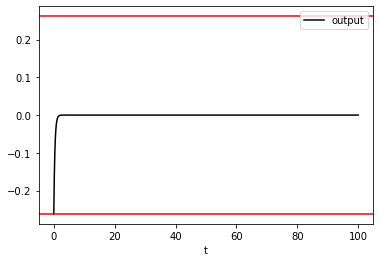

In [7]:
# Параметры PID-регулятора подобраны так, 
# чтобы решением дифференциального уравнения относительно выходного сигнала 
# была функция вида полином*exp(-3t)
P, I, D = 5.55, 4.05, 1.3

# задаём начальную позицию
start_pos = -15 * np.pi / 180.0

# числитель и знаменатель передаточной функции PID-регулятора
PID_num = [D, P, I]
PID_den = [1, 0]

# числитель и знаменатель передаточной функции всей системы
total_sys_num = np.convolve(eng_num, PID_num)
total_sys_den = np.polyadd(total_sys_num, np.convolve(eng_den, PID_den))

# создаём представление системы
total_sys = signal.tf2ss(total_sys_num, total_sys_den)

# задаём временной интервал
t = np.linspace(0.0, 100.0, 10001)

# задаём входной сигнал;
sig = np.zeros(t.size)

# задаём границы применения модели
limit = 15 * np.pi / 180.0

# пропускаем через систему
tout, yout, xout = signal.lsim(total_sys, sig, t, X0=init_cond(P, I, D, start_pos))

# выводим положение маятника
plt.figure()
plt.plot(tout, yout, color='black', label='output')
plt.axhline(limit, color='r')
plt.axhline(-limit, color='r')
plt.legend(loc=0)
plt.xlabel('t')
plt.show()